In [1]:
# import all packages
import pandas as pd 
import numpy as np 
import textwrap 

import seaborn as sns 
import matplotlib.pyplot as plt 

import shap 

from sklearn.preprocessing import StandardScaler 
from sklearn import linear_model 

from sklearn.model_selection import KFold, cross_validate, cross_val_predict, RepeatedKFold, cross_val_score, GridSearchCV 
from sklearn.metrics import r2_score, mean_absolute_error 

import statsmodels.api as sm

/Users/etiennechenevert/opt/anaconda3/envs/qwasd/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<a id='_DataDescriptions'></a>
## Brief Data Descriptions

Getting to know our data is crucial. This way we know what processes we are incorporating into our model, which we are excluding, and how many samples we have to capture the full relationship of vertical accretion. 

In [2]:
url = "https://raw.githubusercontent.com/geo-smart/XAI_coastalLA/main/ESIP_dataset4.csv" # Make sure the url is the raw version of the file on GitHub
df = pd.read_csv(url)
print(df.columns) # lets see what variables we are working with

Index(['Unnamed: 0', 'Accretion Rate (mm/yr)', 'Soil Porewater Salinity (ppt)',
       'Average Height Dominant (cm)', 'NDVI', 'TSS (mg/l)', 'Windspeed (m/s)',
       'Avg. Time Flooded (%)', 'Flood Freq (Floods/yr)',
       'Log Distance to Water (km)', 'Log Distance to River (km)', 'Community',
       'Latitude', 'Longitude', 'Organic Matter (%)', 'Bulk Density (g/cm3)',
       'Tidal Amplitude (cm)', '90th Percentile Flood Depth (cm)',
       '10th Percentile Flood Depth (cm)', 'Avg. Flood Depth (cm)',
       'Std. Deviation Flood Depth (cm)'],
      dtype='object')


In [3]:
# lets know how many variables and how many samples we have to work with
print("Number of samples in dataset: ", len(df))
print("Number of features in the dataset: ", len(df.columns))

Number of samples in dataset:  266
Number of features in the dataset:  21


In [4]:
# There are some unnecessary and/or uninformative variables in here, so lets remove them
df = df.drop([
    'Longitude', 'Latitude', 'Bulk Density (g/cm3)', 'Organic Matter (%)'
], axis=1)

I removed the variables longitude, latitude, bulk density (g/cm3), and organic matter (%) because they do not provide us with an associated transport mechanism or biologic process such as flooding, biomass production, biomass decay, erosion, etc. Latitude and longitude are only geographic descriptions of where sites are situated, making them uninformative towards a process understanding of vertical accretion. While bulk density and organic matter (%) are descriptions of the soil that has already been deposited, rather than *how* it might have been deposited.

In [5]:
outcome = 'Accretion Rate (mm/yr)'
feature_ls = list(df.columns.values[1:-1]) # make a list including all the variables; 
                                           # excluding the categorical Site and Maarsh community variables
print(feature_ls)

['Accretion Rate (mm/yr)', 'Soil Porewater Salinity (ppt)', 'Average Height Dominant (cm)', 'NDVI', 'TSS (mg/l)', 'Windspeed (m/s)', 'Avg. Time Flooded (%)', 'Flood Freq (Floods/yr)', 'Log Distance to Water (km)', 'Log Distance to River (km)', 'Community', 'Tidal Amplitude (cm)', '90th Percentile Flood Depth (cm)', '10th Percentile Flood Depth (cm)', 'Avg. Flood Depth (cm)']


## Variable Descriptions

The remaining variables that will be used in the analysis are: 
* **Accretion Rate (mm/yr)**: The amount of sediment deposited above a datum. Recorded with a 6 to 18 month sampling interval.
* **Soil Porewater Salinity (ppt)**: Measured from a syringe inserted into the soil. Recorded variably to annually.
* **Average Height Dominant (cm)**: Survey measurement of the average height of the dominant vegetation species. Sampled annually. 
* **NDVI**: The Normalized Difference Vegetation Index which is an estimate of aboveground biomass from Landsat 7. Samples consisted of an 8 day averages only collected during the months of peak biomass, July-August.
* **TSS (mg/l)**: Estimate of Total Suspended Sediment (TSS) from MODIS. With a 2-day sampling (recurrance) interval.
* **Windspeed**: Reanalysis data from the Global Wind Atlas available from Google Earth Engine (GEE) (The Global Wind Atlas 3 2022).
* **Tidal Amplitude (cm)**: The average daily difference between the highest recorded and lowest hourly water-level as recorded from an underwater sonde.
* **Average Time Flooded (%)**: The percentage of time in which the water-level exceeds the elevation of the marsh. Calculated from hourly water-level measurements from an underwater sonde.
* **Flood Frequency (Floods/yr)**: The number of times that the water-level exceeds the elevation of the marsh. Calculated from hourly water-level measurements from an underwater sonde.
* **Average Flood Depth (cm)**: The average waterlevel when the water-level is higher than the marsh elevation. Calculated from hourly water-level measurements from an underwater sonde. 
* **90th Percentile Flood Depth (cm)**: The 90th percentile of the time series distribution of average flood depth. Calculated from hourly water-level measurements from an underwater sonde.
* **10th Percentile Flood Depth (cm)**: The 10th percentile of the time series distribution of average flood depth. Calculated from hourly water-level measurements from an underwater sonde.
* **Std. Deviation Flood Depth (cm)**: The standard deviation of the time series distribution of average flood depth. Calculated from hourly water-level measurements from an underwater sonde. 
* **Log Distance to Water (km)**: The log of the distance to the nearest water pixel (90% recurrence). As calcculated by the JRC Global Surface Water Dataset (Pekkel et al 2016).
* **Log Distance to River (km)**: The log of the distance to the nearest Global River Width from Landsat (GRWL) dataset river vectors taken from GEE (Allen and Pavelsky 2018). 
* **Community**: Marsh Community (Freshwater, Intermediate, Brackish, Saline, Swamp) determined from surveys of                        vegetation and salinity gradients.

Note that all of these variables spanned either the lifespan of a CRMS site which largely encapsulates 2007 to 2022 (Wagner and Haywood III 2022). 

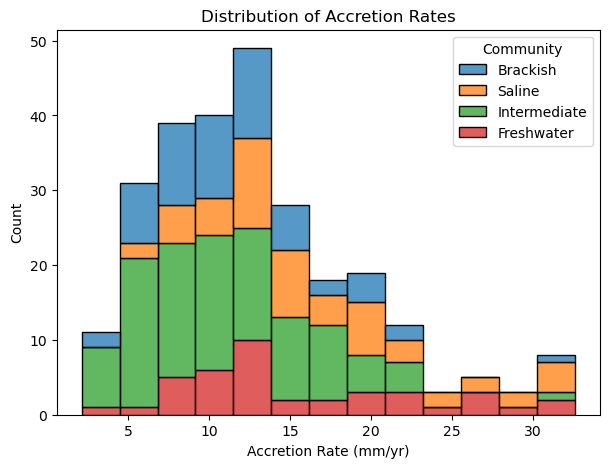

In [6]:
# Let's visualize what we want to predict, 'Accretion Rate (mm/yr)'
f = plt.figure(figsize=(7, 5))
ax = f.add_subplot(1, 1, 1)
sns.histplot(data=df, ax=ax, stat="count", multiple="stack",
             x="Accretion Rate (mm/yr)", kde=False,
             hue="Community",
             element="bars", legend=True)
ax.set_title("Distribution of Accretion Rates")
ax.set_xlabel("Accretion Rate (mm/yr)")
ax.set_ylabel("Count")
plt.show()

In [7]:
# Let's define our target and design matrix for our ML job
target = df[outcome]
phi = df.drop(['Unnamed: 0', 'Accretion Rate (mm/yr)', 'Community'], axis=1)

In [8]:
# Let's get a picture of the target variable, vertical accretion
target.describe()

count    266.000000
mean      13.093916
std        6.449721
min        2.128280
25%        8.226964
50%       12.174938
75%       16.227400
max       32.589286
Name: Accretion Rate (mm/yr), dtype: float64

In [9]:
# Some decriptive statistics to get a picture of the distributions
phi.describe()

,Soil Porewater Salinity (ppt),Average Height Dominant (cm),NDVI,TSS (mg/l),Windspeed (m/s),Avg. Time Flooded (%),Flood Freq (Floods/yr),Log Distance to Water (km),Log Distance to River (km),Tidal Amplitude (cm),90th Percentile Flood Depth (cm),10th Percentile Flood Depth (cm),Avg. Flood Depth (cm),Std. Deviation Flood Depth (cm)
count,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000
mean,7.186861,112.439643,0.353358,31.821080,6.683651,39.207975,261.107686,0.342556,3.026571,9.283287,24.836617,0.314712,9.731371,11.897189
std,6.039870,28.938786,0.110811,13.033298,0.272169,28.512498,549.612559,1.077911,1.004707,9.204314,9.858570,1.560128,5.785805,3.026577
min,0.100000,54.860000,0.057249,0.000000,5.864558,0.000000,0.000000,-3.534766,-1.828729,0.060442,0.914400,0.000000,1.173515,4.595155
25%,2.425000,97.000000,0.292554,28.556742,6.525110,15.867526,51.426390,-0.110944,2.519015,0.312294,18.267426,0.000000,5.835615,10.014167
50%,5.600000,108.300000,0.364691,32.970487,6.703245,39.127680,161.037234,0.268765,3.257276,6.584424,24.292560,0.000000,8.483845,11.656643
75%,10.300000,122.100000,0.399708,39.331860,6.872427,59.170743,250.736063,1.187492,3.814583,18.043368,29.794200,0.000000,12.263635,13.760751
max,27.500000,315.800000,0.627081,65.011248,7.315856,99.999999,4693.096330,2.504450,4.314392,27.500165,65.257680,18.592800,41.731574,24.649485


## Scaling Features

It is important to scale our features due to potential biases influencing the relative influences of features due to the varying numerical values of the features. For instance, for two features of the same influence in a linear regression, if a feature contains very low values, then the learned weight coefficient for that feature will be notably larger than the other feature with larger values. This is due to having to multiply the smaller vector by a larger weight to achieve the same output as the larger feature vector. Note that both the Bayesian Linear Regression and the Gaussian Process Regression have this scaling requirement. 

In [14]:
# Scale variables to minimize bias between features
scalar = StandardScaler()
data = pd.DataFrame(scalar.fit_transform(phi), columns=phi.columns.values)